get data True b'OWON,FDS4112S,2225048,V1.0.2'


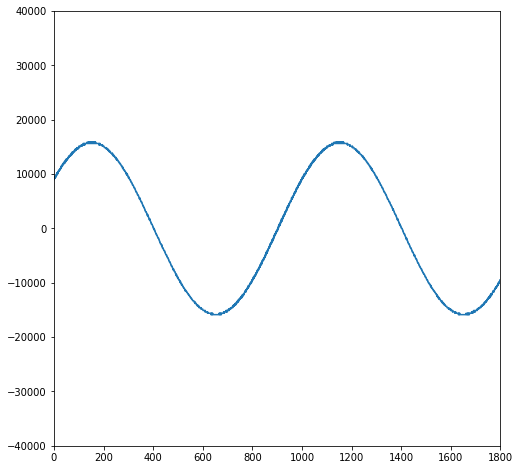

In [8]:
from socket import *
import _thread
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def get_host_ip():
    try:
        s = socket(AF_INET, SOCK_DGRAM)
        s.connect(('8.8.8.8', 80))
        ip = s.getsockname()[0]
    finally:
        s.close()
        return ip

g_serve_ip = get_host_ip()
g_serve_port = 3000  
g_tcp_socket = socket(AF_INET, SOCK_STREAM)

g_recv_thread_loop = True
g_recv_get_data = False
g_recv_data_buf = ''

def recv_thread():
    global g_recv_get_data
    global g_recv_data_buf
    g_recv_get_data = False
    while g_recv_thread_loop:
        try:
            g_recv_data_buf = g_tcp_socket.recv(10000) 
            g_recv_get_data = True
        except:
            print('close tcp socket.') 
        
def scpi_query(delay_s, cmd_str):
    global g_recv_get_data
    global g_recv_data_buf
    g_recv_get_data = False
    count = 0
    g_tcp_socket.send(cmd_str.encode("gbk")) 
    while True:
        if (g_recv_get_data):
            return g_recv_get_data, g_recv_data_buf
        else:
            time.sleep(0.1)
            count += 1
            if (count % 20 == 0):
                print(g_recv_get_data, count, delay_s)
            if (count >= delay_s * 10):
                print("Error: ", count, delay_s)
                return g_recv_get_data, ''

def set_up_tcp_client(): 
    global recv_thread
    g_tcp_socket.connect((g_serve_ip, g_serve_port))  
    try:
        _thread.start_new_thread(recv_thread, ())
    except:
        print ("Error: can not start thread")

def scpi_test_idn():
    get_data, recv_data_buf = scpi_query(5, '*IDN?\r\n')
    print('get data', get_data, recv_data_buf)

def get_scope_data():
    get_data, recv_data_buf = scpi_query(10, ':DATA:WAVE:SCREen:CH1?\r\n')
    if (get_data):
        rec_scope_data_buf = recv_data_buf[4:] #delete 4 lenght bytes
        scope_data_buf_int16 = np.frombuffer(rec_scope_data_buf, np.int16)
        return True, scope_data_buf_int16
    else:
        print("Error: can not get Scope data")
        return False, 'error'

def scope_data_to_gen():
    fig = plt.figure(figsize=(8, 8))
    get_data, scope_data_buf_int16 = get_scope_data()

    if (get_data):
        data_range = np.arange(scope_data_buf_int16.size)
        data_size = scope_data_buf_int16.size
        plt.plot(data_range, scope_data_buf_int16)
        plt.axis([0, data_size, -40000, 40000])
        plt.show()

def exit():
    global g_recv_thread_loop
    g_recv_thread_loop = False
    g_tcp_socket.close()


set_up_tcp_client()
scpi_test_idn()
scope_data_to_gen()
exit()